Listings, including full descriptions and average review score
Reviews, including unique id for each reviewer and detailed comments
Calendar, including listing id and the price and availability for that day

Purpose

Determine ratings based on host's property details and their relationship with their customers.
Listings and Reviews data wil be merged for this analysis.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

review_df = pd.read_csv('seattle_reviews.csv')
listings_df = pd.read_csv('seattle_listings.csv')
calendar_df = pd.read_csv('seattle_calendar.csv')

In [2]:
review_df.head(n=2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...


In [3]:
listings_df.head(n=2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [4]:
calendar_df.head(n=2)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00


In [5]:
calendar_df = calendar_df.sort_values('listing_id').drop_duplicates(subset=['date', 'price'], keep='last')


In [6]:
calendar_df.head(n=2)


,listing_id,date,available,price
153418,11012,2016-05-01,t,$310.00
153419,11012,2016-05-02,t,$310.00


In [7]:
# remove nans from dates and prices in the calendar df
calendar_df = calendar_df.dropna(subset=['date'], axis=0)
calendar_df = calendar_df.dropna(subset=['price'], axis=0)


# making a bool series for duplicated dates and prices in the calendar df
bool_series = calendar_df.duplicated(subset=['date','price'], keep=False)

In [8]:
calendar_df.head()

,listing_id,date,available,price
153418,11012,2016-05-01,t,$310.00
153419,11012,2016-05-02,t,$310.00
153420,11012,2016-05-03,t,$310.00
153422,11012,2016-05-05,t,$310.00
153393,11012,2016-04-06,t,$310.00


In [9]:
# Create floats of the prices in the calendar df
calendar_df[calendar_df.columns[3:]] = calendar_df[calendar_df.columns[3:]].replace('[\$,]', '', regex=True).astype(float)


In [10]:
calendar_df.head()


,listing_id,date,available,price
153418,11012,2016-05-01,t,310.0
153419,11012,2016-05-02,t,310.0
153420,11012,2016-05-03,t,310.0
153422,11012,2016-05-05,t,310.0
153393,11012,2016-04-06,t,310.0


In [11]:
# Create floats of the prices in the listings df
listings_df.price = listings_df.price.replace('[\$,]', '', regex=True).astype(float)


In [12]:
# Convert dates to datetime to plot AirBnB pricing across 2016
calendar_df['date'] = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in calendar_df['date']]
# -- calendar_df.loc[:, 'date'] = pd.to_datetime(calendar_df['date'], format='%Y-%m-%d')
# -- calendar_df.info()

# Q1. How does pricing change during 2016?

Text(0, 0.5, 'Price/$')

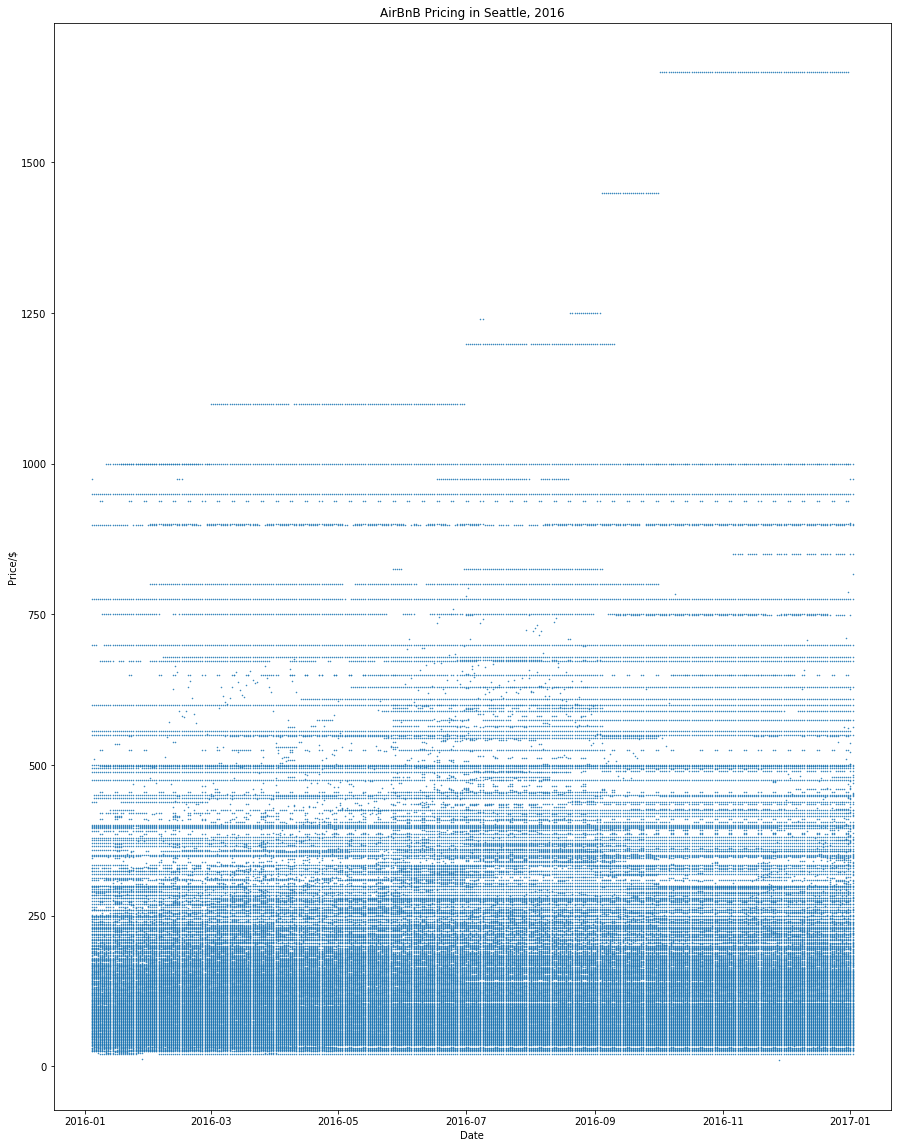

In [39]:
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(111)
ax.plot_date(x=calendar_df.date, y=calendar_df.price, marker='.', ms = 1.0, xdate=True)

ax.set_title('AirBnB Pricing in Seattle, 2016')
ax.set_xlabel('Date')
ax.set_ylabel('Price/$')

#### There's a larger variety pf prices over the summer months

#### There appears to be more prices/properties available during the summer

#### The maximum price increases as the year progresses

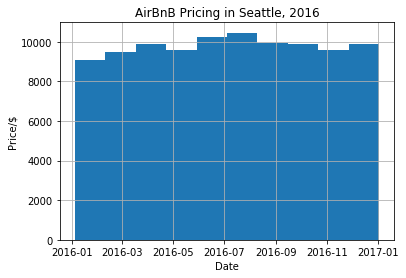

In [14]:
calendar_df.date.hist()

plt.title('AirBnB Pricing in Seattle, 2016')
plt.xlabel('Date')
plt.ylabel('Price/$')

plt.show()


### Seattle pricing increases to the highest over June to August

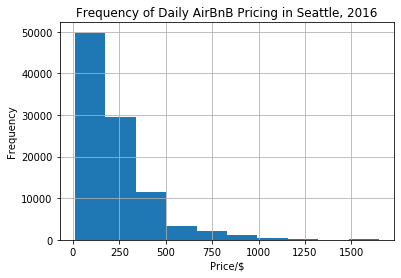

In [15]:
calendar_df.price.hist()

plt.title('Frequency of Daily AirBnB Pricing in Seattle, 2016')
plt.xlabel('Price/$')
plt.ylabel('Frequency')

plt.show()


### The most frequent range of prices is up to 200 US dollars

num_rows_listings_df = listings_df.shape[0] #Provide the number of rows in the dataset
num_cols_listings_df = listings_df.shape[1] #Provide the number of columns in the dataset
print(num_rows_listings_df)
print(num_cols_listings_df)

3818
92

num_rows_calendar_df = calendar_df.shape[0] #Provide the number of rows in the dataset
num_cols_calendar_df = calendar_df.shape[1] #Provide the number of columns in the dataset
print(num_rows_calendar_df)
print(num_cols_calendar_df)

98096
4

In [40]:
# Before dropping columns for the model fit
listings_df.head(n=1)

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,within a few hours,96%,100%,f,Queen Anne,3.0,3.0,t,t,...,10.0,10.0,10.0,9.0,10.0,moderate,f,f,2,4.07


In [41]:
# Drop columns with urls, dates
listings_df = listings_df.drop(['listing_url','scrape_id','last_scraped','name','summary',
 'space', 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes','street',
 'transit','host_verifications',
 'picture_url','xl_picture_url',
 'host_since','neighbourhood',
 'neighbourhood_cleansed',
 'host_location','city',
 'state','zipcode','market',
 'smart_location','country_code',
 'country','calendar_last_scraped',
 'first_review','last_review',
 'requires_license',
 'jurisdiction_names',
 'instant_bookable',
 'is_location_exact', 'has_availability',
 'host_about','thumbnail_url', 'medium_url',
 'host_id', 'host_url', 'host_name','host_thumbnail_url','host_picture_url','license'],axis=1)

KeyError: "['listing_url' 'scrape_id' 'last_scraped' 'name' 'summary' 'space'\n 'description' 'experiences_offered' 'neighborhood_overview' 'notes'\n 'street' 'transit' 'host_verifications' 'picture_url' 'xl_picture_url'\n 'host_since' 'neighbourhood' 'neighbourhood_cleansed' 'host_location'\n 'city' 'state' 'zipcode' 'market' 'smart_location' 'country_code'\n 'country' 'calendar_last_scraped' 'first_review' 'last_review'\n 'requires_license' 'jurisdiction_names' 'instant_bookable'\n 'is_location_exact' 'has_availability' 'host_about' 'thumbnail_url'\n 'medium_url' 'host_id' 'host_url' 'host_name' 'host_thumbnail_url'\n 'host_picture_url' 'license'] not found in axis"

In [18]:
# After dropping columns 
listings_df.head(n=1)

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,within a few hours,96%,100%,f,Queen Anne,3.0,3.0,t,t,...,10.0,10.0,10.0,9.0,10.0,moderate,f,f,2,4.07


In [19]:
#Provide a set of columns with more than 75% of the values missing
most_missing_review_cols = set(review_df.columns[review_df.isnull().sum()/len(review_df) > .5])
most_missing_review_cols


set()

In [20]:
# Square feet wouldn't be a good variable to use so let's drop
most_missing_listings_cols = set(listings_df.columns[listings_df.isnull().sum()/len(listings_df) > .95])
most_missing_listings_cols


{'square_feet'}

In [21]:
most_missing_calendar_cols = set(calendar_df.columns[calendar_df.isnull().sum()/len(calendar_df) > .5])
most_missing_calendar_cols


set()

In [22]:
# Merge the listings with the calendar dfs
df = listings_df.merge(calendar_df, left_on='id', right_on='listing_id')    #merge(review_df, left_on='id', right_on='listing_id')


In [81]:
# Compute the correlation matrix
corr_p = df.corr(method ='pearson')

In [82]:
# Compute the correlation matrix
corr_k = df.corr(method ='kendall')

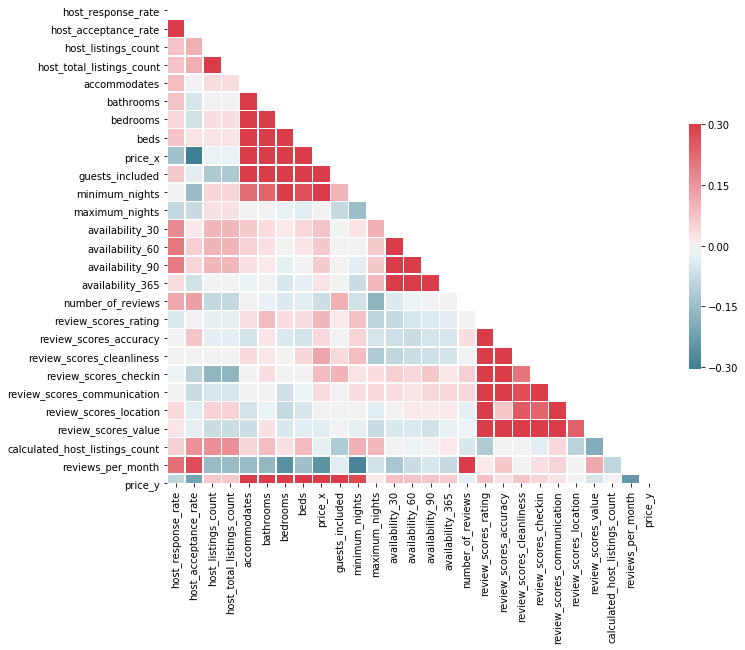

In [83]:
# Generate a mask for the upper triangle
mask_p = np.triu(np.ones_like(corr_p, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_p, mask=mask_p, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

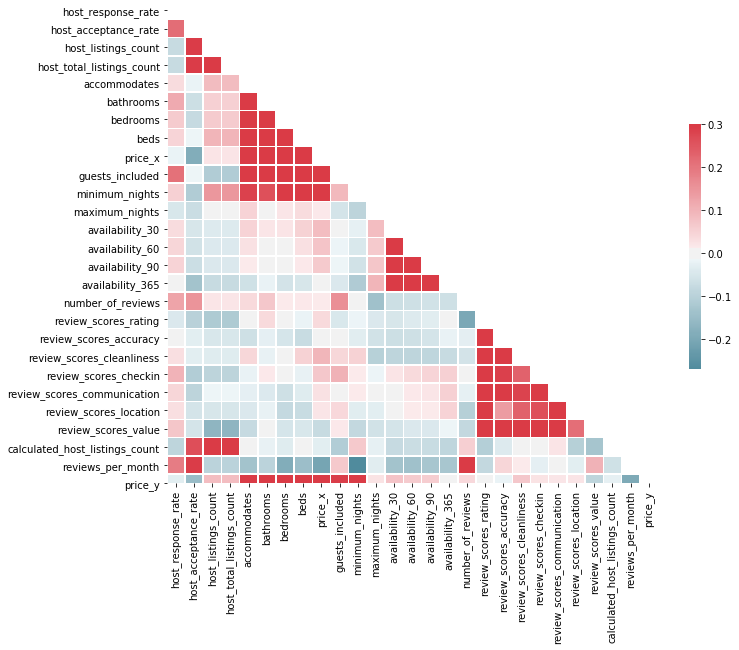

In [84]:
mask_k = np.triu(np.ones_like(corr_k, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr_k, mask=mask_k, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
BBox = (df.longitude.min(),   df.longitude.max(),      
         df.latitude.min(), df.latitude.max())

print(BBox)


(-122.41636191405388, -122.24060703053992, 47.50845296779498, 47.73264717600907)


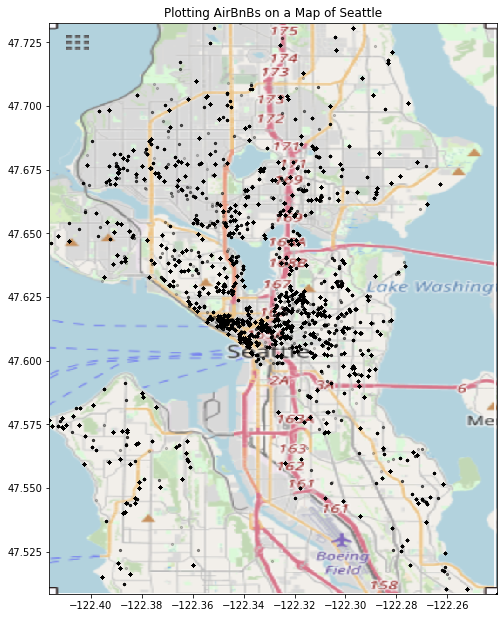

In [24]:
sea_m = plt.imread('airbnb_sea.png')

fig, ax = plt.subplots(figsize = (12,10.5))
ax.scatter(df.longitude, df.latitude, zorder=1, alpha= 0.2, c='k', s=5)
ax.set_title('Plotting AirBnBs on a Map of Seattle')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(sea_m, zorder=0, extent = BBox, aspect= 'equal')


In [25]:
# Drop columns with urls, dates
df = df.drop(['id','latitude','longitude','listing_id'],axis=1)

In [26]:
df = df.drop(['date'],axis=1)

In [27]:
df = df.drop(['available'],axis=1)

In [28]:
df.price_x.head()

0    975.0
1    975.0
2    975.0
3    975.0
4    975.0
Name: price_x, dtype: float64

In [29]:
threshold = 0.75
#Dropping columns with missing value rate higher than threshold -- square_feet has less than 5% data
df = df[df.columns[df.isnull().mean() < threshold]]

#Dropping rows with missing value rate higher than threshold
df = df.loc[df.isnull().mean(axis=1) < threshold]

In [30]:
df.shape

(98096, 46)

Reminder: Purpose

Determine rating score based on host's property details and their relationship with their customers.
Listing and Review data wil be merged for this analysis.

Review scores increase with bathrooms, bedrooms, minimum nights

In [31]:
# Remove percentage sign from host_response_rate
df['host_response_rate'] = df['host_response_rate'].astype(str).map(lambda x: x.rstrip('%'))
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(str).map(lambda x: x.rstrip('%'))
# Next: Drop nans and convert to ints


In [32]:
# Fill response rates with zero (rather than the mean)
df['host_response_rate'] = df['host_response_rate'].astype(float).fillna(0)
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(float).fillna(0)


In [33]:
# Remove all NaNs

see_nonans = df.dropna()
see_nonans.shape

#(9978, 48) Loss 9000 rows!

(9978, 46)

# Numerical Variables

In [58]:
# Subset to a dataframe only holding the numerical columns
num_df = df.select_dtypes(include=['float','int']).copy()

# Print how many numerical columns are in the dataframe
num_df.shape[1]

27

In [59]:
# Copy of the numerical df
num_df_copy = num_df.copy()
num_cols_lst = num_df.columns
num_cols_lst # list of numerical columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price_x', 'guests_included', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'price_y'],
      dtype='object')

In [61]:
drop_num_df = num_df_copy.dropna(subset=['review_scores_value'], axis=0)

# Mean function
fill_mean = lambda col: col.fillna(col.mean())
# Fill the mean
fill_df = drop_num_df.apply(fill_mean, axis=0)


In [62]:
#Split into explanatory and response variables
X = fill_df[['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price_x', 'guests_included', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'calculated_host_listings_count',
       'reviews_per_month', 'price_y']]
y = fill_df['review_scores_value']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.48752052019465053 on 18639 values.'

# Categorical Variables

In [53]:
# Subset to a dataframe only holding the categorical columns
cat_df = df.select_dtypes(include=['object']).copy()

# Print how many categorical columns are in the dataframe
cat_df.shape[1]

19

In [54]:
# Copy of the categorical df
cat_df_copy = cat_df.copy()
cat_cols_lst = cat_df.columns
cat_cols_lst # list of categorical columns

Index(['host_response_time', 'host_is_superhost', 'host_neighbourhood',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'bed_type', 'amenities', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'extra_people', 'calendar_updated',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')

In [56]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in cat_cols:
        try:
            # for each category add dummy var, drop original column
            # concat columns together as the original cat_cols are dropped and the new dummy_cols are created
            # drop_first removes NaN; False keeps NaN in the df
            # dummy_na=False will not include NaNs in the dummy_df
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    
    return df

In [57]:
#Dropping rows where the review_scores_value has missing values
df = df.dropna(subset=['review_scores_value'], axis=0)

#Use your newly created function
df_new = create_dummy_df(df, cat_cols_lst, dummy_na=False)

# Show a header of df_new to check
print(df_new.shape)



(62129, 1622)


In [85]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    #Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)

    #Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    #Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)

    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test


#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df_new, 'review_scores_value', cat_cols_lst, dummy_na=False)




In [86]:
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.9987884517043597.  The rsquared on the test data was -4.9559180063179533e+23.


In [64]:
df_new2 = create_dummy_df(df, cat_cols_lst, dummy_na=True)
print(df_new2.shape)


(62129, 1641)


In [65]:
# Add mean of the column to NaN rows
fill_mean = lambda col: col.fillna(col.mean())
fill_df = df_new2.apply(fill_mean, axis=0)

In [74]:
fill_df = fill_df.drop_duplicates()

In [ ]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    #Drop the rows with missing reviews
    drop_rev_df = df.dropna(subset=['review_scores_value'], axis=0)
    
    df = df.dropna(subset=['review_scores_value'], axis=0)
    y = df['review_scores_value']
    
    #---- no need: df = df.drop([''], axis=1)
    
    #For each numeric variable in X, fill the column with the mean value of the column.
    #Subset to a dataframe only holding the numeric columns
    num_df = df.select_dtypes(include=['float','int']).columns
    for col in num_df:
        df[col].fillna((df[col].mean()), inplace=True)        
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in cat_vars:
        # for each category, add dummy variables, and drop the original categorical column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
    
#Use the function to create X and y
X, y = clean_data(df)

In [34]:
no_nulls = set(cat_df[cat_df.columns[~cat_df.isnull().any()]].columns.tolist())
print(no_nulls)

NameError: name 'cat_df' is not defined

In [ ]:
more_than_half_missing = set(cat_df.columns[cat_df.isnull().sum()/len(df) > .50])
print(more_than_half_missing)

# Predict review_scores_value

In [ ]:
# Convert dates back to strings
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))


In [ ]:
# Convert prices to floats
df.price_x = df.price_x.replace('[\$,]', '', regex=True).astype(float)
df.price_y = df.price_y.replace('[\$,]', '', regex=True).astype(float)


In [ ]:
# Drop prices from the df
# ----- df = df.drop(['price_x','price_y'],axis=1)


In [ ]:
print(X, y)

In [ ]:
#Create training and test sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)


In [ ]:
#Instantiate a LinearRegression model with normalized data
lm_model = LinearRegression(normalize=True)


In [ ]:
#Fit your model to the training data
lm_model.fit(X_train, y_train)


In [ ]:
#Predict the response for the training data and the test data
#Obtain an rsquared value for both the training and test data
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)


In [ ]:
#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)


In [ ]:
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))


In [ ]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    
    #Drop the rows with missing response values
    df = df.dropna(subset=['review_scores_value'], axis=0)
    
    #Drop columns with NaN for all the values; i.e. if all values are NaN, drop the column
    df = df.dropna(how='all', axis=1)
    
    #Use create_dummy_df to dummy categorical columns
    df_new = create_dummy_df(df, cat_cols, dummy_na=dummy_na)
    
    # Fill the mean of the column for any missing values
    fill_mean = lambda col: col.fillna(col.mean())
    fill_df = df_new.apply(fill_mean, axis=0)

    #Split your data into an X matrix and a response vector y
    #X=explanatory and y=response variables
    X = fill_df.drop(response_col, axis=1)
    y = fill_df[response_col]

    #Create training and test sets of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    #Instantiate a LinearRegression model with normalized data
    lm_model = LinearRegression(normalize=True)
    
    #Fit your model to the training data
    lm_model.fit(X_train, y_train)

    #Predict the response for the training data and the test data
    #Obtain an rsquared value for both the training and test data
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    
    
    "The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [ ]:
#Create a copy of the dataframe
cat_df_copy = cat_df.copy()
# cat_df: cat_copy_cols = cat_df_copy.columns
# Drop cols in place: cat_df_copy.drop(cat_df_copy.columns, axis=1, inplace=True)
# Get dummies of cat cols including NaNs: pd.get_dummies(df[cat_cols_lst],dummy_na=True)

#Pull a list of the column names of the categorical variables
cat_cols_lst = cat_df_copy.columns

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in cat_cols:
        try:
            # for each category add dummy var, drop original column
            # concat columns together as the original cat_cols are dropped and the new dummy_cols are created
            # drop_first removes NaN; False keeps NaN in the df
            # dummy_na=False will not include NaNs in the dummy_df
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    
    return df

In [ ]:
#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df, 'review_scores_value', cat_cols_lst, dummy_na=False)



In [ ]:
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))


In [ ]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)